[[0.0444122  0.0363204  0.02920359]
 [0.07601015 0.06133953 0.0481269 ]
 [0.04779695 0.03869295 0.03007371]
 [0.0533682  0.04416979 0.03523049]
 [0.13757214 0.11500326 0.09610717]
 [0.04380108 0.03470654 0.02806495]]
[[0.0444122  0.07601015 0.04779695 0.0533682  0.13757214 0.04380108]
 [0.0363204  0.06133953 0.03869295 0.04416979 0.11500326 0.03470654]
 [0.02920359 0.0481269  0.03007371 0.03523049 0.09610717 0.02806495]]


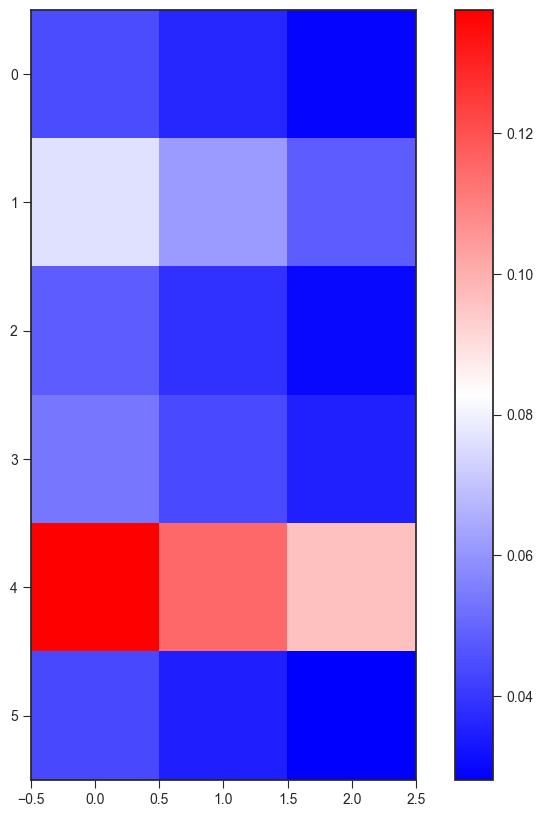

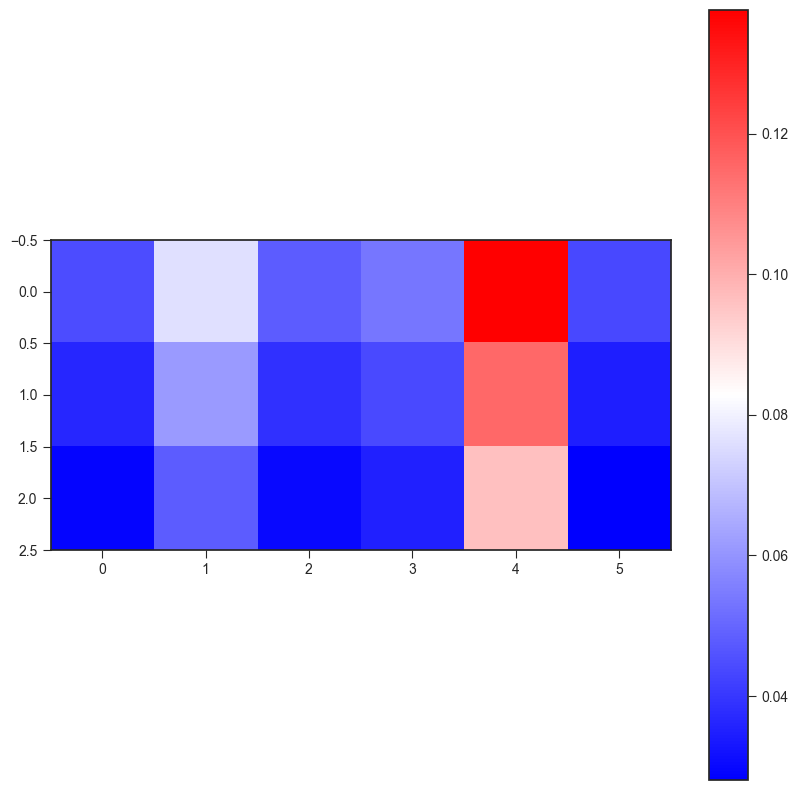

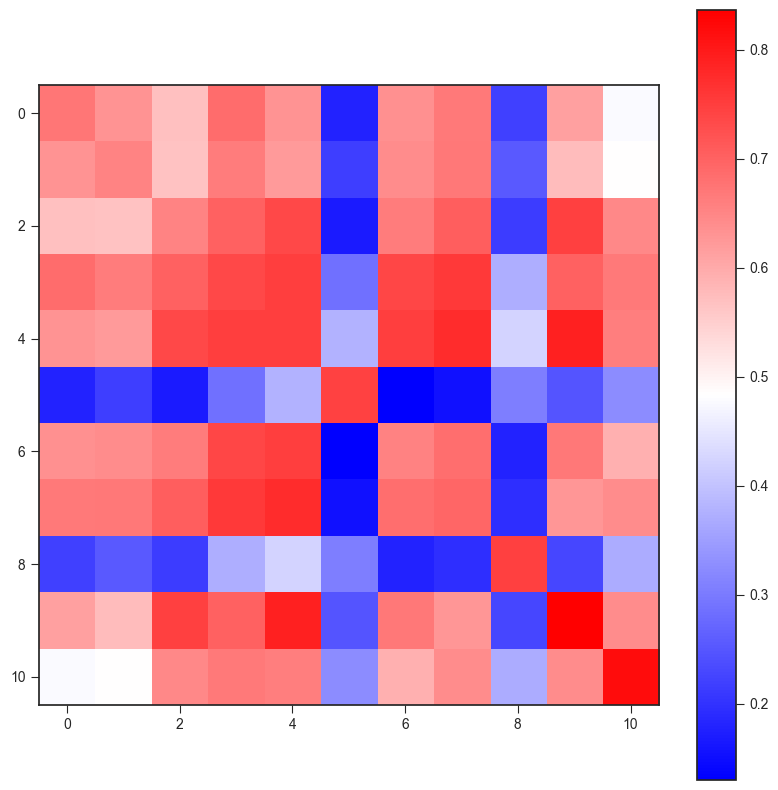

In [194]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy import linalg


from scipy.special import rel_entr

import numpy as np
hmm_list = []
for i in range(1,13):
    if i!=3:
        hmm_list.append(pickle.load(open("hmms_sbj"+str(i),'rb'))[0][0])

def gini(x):
    x = np.abs(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    # print(diffsum / (len(x)**2 * np.mean(x)))
    return diffsum / (len(x)**2 * np.mean(x))

def normalized_gini(x):
  N = np.max(x.shape[0])
  return N*gini(x)/(N-1)

def similarity(Q):
  sum_gini_rows = 0
  sum_gini_cols = 0
  n1 = Q.shape[0]
  n2 = Q.shape[1]
  for i in range(n1):
    # print(normalized_gini(Q[i,:]))
    sum_gini_rows += normalized_gini(Q[i,:])
  for j in range(n2):
    sum_gini_cols += normalized_gini(Q[:,j])
  return 0.5*(sum_gini_rows/n1+sum_gini_cols/n2)

def KLBstates(ps1,ps2):
  ps1 = ps1.tolist()
  ps2 = ps2.tolist()
  return (sum(rel_entr(ps1,ps2))+sum(rel_entr(ps2,ps1)))/2


def stationary_states(A):
  # print(A)
  A_T = A.T
  n = A.shape[0]
  A_T[n-1,:] = np.ones((n,))
  for i in range(n-1): 
    A_T[i,i] = A_T[i,i]-1
  # print(A_T)
  # A_T[1,0] = A_T[1,0]-1
  b = np.zeros((n,1))
  b[b.size-1] = 1
  # print(b)
  pi = np.linalg.inv(A_T).dot(b)
  # print(pi)
  assert all(pi>0)
  return pi.T

def Qmatrix(A1,A2,B1,B2):
  n1 = A1.shape[0]
  n2 = A2.shape[0]
  stationary_1 = stationary_states(A1)
  stationary_2 =  stationary_states(A2)
  Q = np.zeros((n1,n2))
  for i in range(n1):
    for j in range(n2): 
      # print("shape:",stationary_1.shape)
      Q[i,j] =  stationary_1[0,i]*stationary_2[0,j]*KLBstates(B1[i,:],B2[j,:])
      
      # print("KLB",KLBstates(B1[i,:],B2[j,:]),B1.shape)
  ES =np.sum(Q)
  Q = Q/ES
  return Q

import pickle
from pyhhmm.multinomial import MultinomialHMM
import os
def compute_adjacency_matrix(mm_list):#con base en la lista de modelos de markov, formar una matriz de adjacencia
                                      #esta representa un grafo con pesos
                                      #cada peso (entrada de la matriz) es la similaridad entre un modelo y otro
    adj_matrix = np.zeros((len(mm_list),len(mm_list)))
    for i in range(len(mm_list)):
        for j in range(len(mm_list)):
            A1 = mm_list[i].A.copy()
            A2 = mm_list[j].A.copy()
            B1 = mm_list[i].B[0].copy()
            B2 = mm_list[j].B[0].copy()
            # print("B:",B2.shape)
            Q = Qmatrix(A1,A2,B1,B2);
            adj_matrix[i,j]=similarity(Q)
            if (i == 5 and j == 1) or (i == 1 and j == 5):
              plt.figure(figsize=(10,10))
              _=plt.imshow(Q,cmap='bwr')
              plt.colorbar()
              print(Q)
    return adj_matrix

adjacency_matrix_s = compute_adjacency_matrix(hmm_list)
# print(adjacency_matrix_s)
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
_=plt.imshow(adjacency_matrix_s,cmap='bwr')
plt.colorbar()


In [197]:

from scipy import sparse, linalg
import pandas as pd
from sklearn.cluster import KMeans

graph_laplacian= sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
 
eigenvals, eigenvcts = linalg.eig(graph_laplacian)

eigenvals_sorted_indices = np.argsort(eigenvals)


indices = eigenvals_sorted_indices[:3]

proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]

k_means = KMeans(random_state=25, n_clusters=3)
k_means.fit(proj_df)
cluster = k_means.predict(proj_df)
print(cluster)


[0 0 0 0 0 1 0 0 2 0 0]
